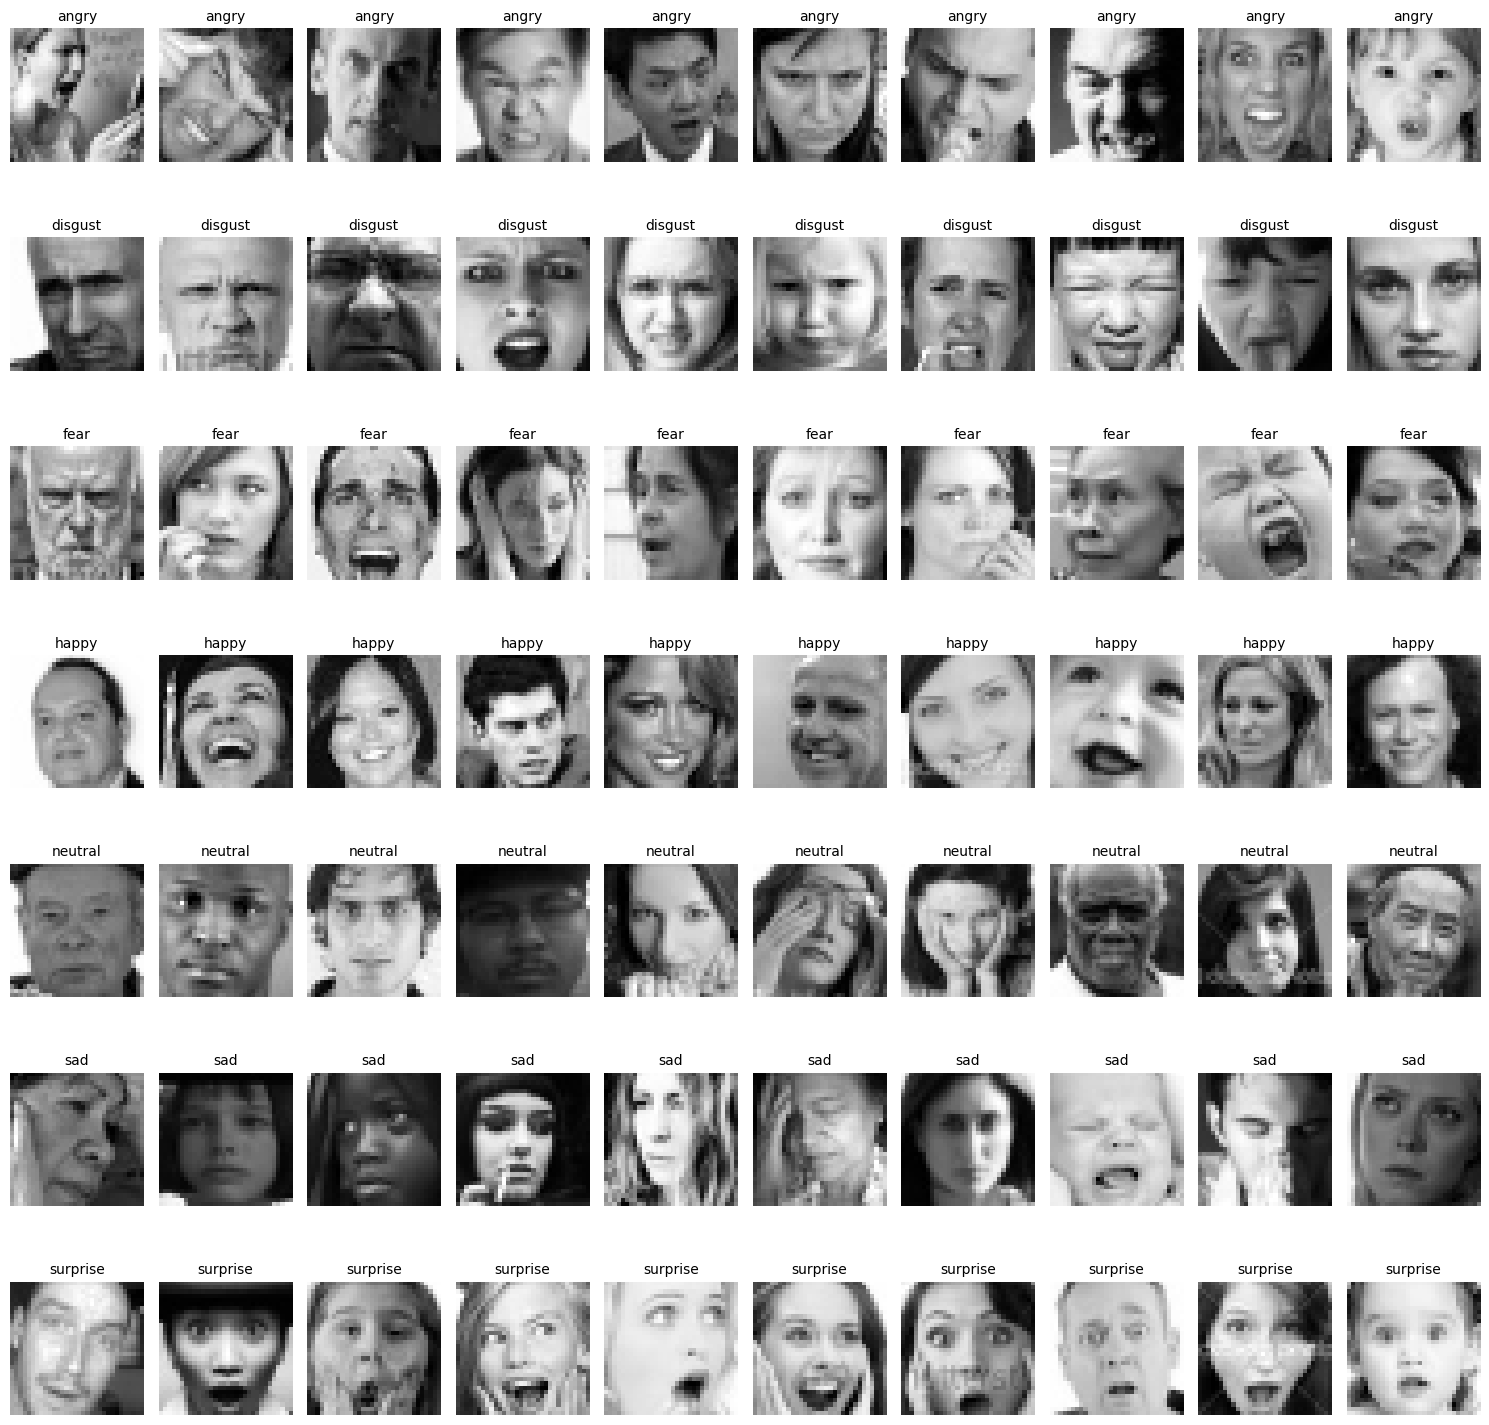

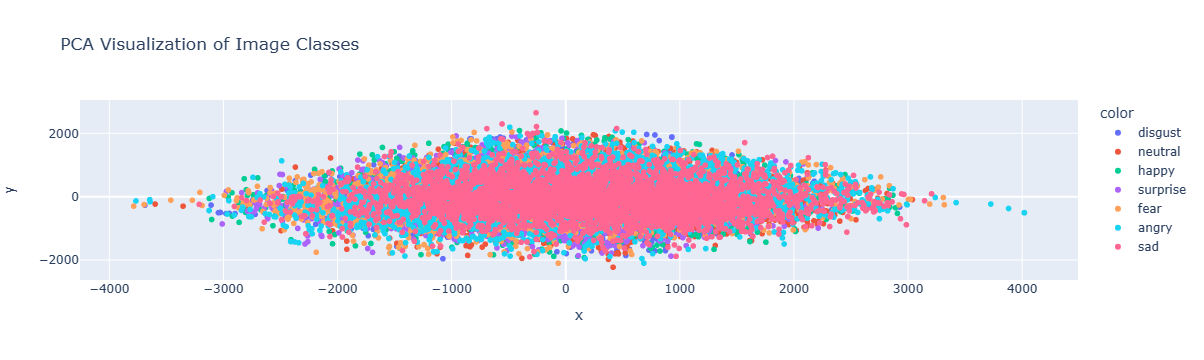

Epoch [1/100], Loss: 2.399154885955479
Epoch [2/100], Loss: 1.7751745943073822
Epoch [3/100], Loss: 1.7359425126824282
Epoch [4/100], Loss: 1.6792593455150961
Epoch [5/100], Loss: 1.5927278028472882
Epoch [6/100], Loss: 1.4636644559403034
Epoch [7/100], Loss: 1.2599411750003457
Epoch [8/100], Loss: 1.0360732883283148
Epoch [9/100], Loss: 0.8198986779770535
Epoch [10/100], Loss: 0.6392946416166881
Epoch [11/100], Loss: 0.4717577237047647
Epoch [12/100], Loss: 0.35222330902547533
Epoch [13/100], Loss: 0.2660522957159807
Epoch [14/100], Loss: 0.23962365820347512
Epoch [15/100], Loss: 0.20263309294072318
Epoch [16/100], Loss: 0.16646710489727387
Epoch [17/100], Loss: 0.1649024630591057
Epoch [18/100], Loss: 0.1753189157965237
Epoch [19/100], Loss: 0.14065595342563486
Epoch [20/100], Loss: 0.1199988212418589
Epoch [21/100], Loss: 0.17823789866016598
Epoch [22/100], Loss: 0.13972406541390928
Epoch [23/100], Loss: 0.14246468103514212
Epoch [24/100], Loss: 0.11085706507015623
Epoch [25/100], L

In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

warnings.simplefilter(action='ignore', category=FutureWarning)

tr_dir = 'train'
te_dir = 'test'

def ld_imgs(dir_p):
    imgs, lbls = [], []
    for em in os.listdir(dir_p):
        for f in os.listdir(os.path.join(dir_p, em)):
            img = cv2.imread(os.path.join(dir_p, em, f), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (32, 32))
                imgs.append(img.reshape(32, 32))  # Remove the channel dimension
                lbls.append(em)
    return np.array(imgs), np.array(lbls)

tr_imgs, tr_lbls = ld_imgs(tr_dir)
te_imgs, te_lbls = ld_imgs(te_dir)

# Display sample images from each class
def ds_smp(imgs, lbls, n_smp=5):
    smp_imgs = []
    cls_names = np.unique(lbls)
    for cls_name in cls_names:
        cls_indices = np.where(lbls == cls_name)[0][:n_smp]
        smp_imgs.extend(imgs[cls_indices])
    return smp_imgs, cls_names

n_smp = 10
smp_imgs, cls_names = ds_smp(tr_imgs, tr_lbls, n_smp)

# Plot sample images in a grid
n_cls = len(cls_names)
fig, axs = plt.subplots(n_cls, n_smp, figsize=(15, 15))
for i, cls_name in enumerate(cls_names):
    cls_indices = np.where(tr_lbls == cls_name)[0][:n_smp]
    for j, idx in enumerate(cls_indices):
        axs[i, j].imshow(tr_imgs[idx], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(cls_name, fontsize=10)

plt.tight_layout()
plt.show()

# Combine training and test labels
all_labels = np.concatenate((tr_lbls, te_lbls))

# Fit the LabelEncoder on the combined labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Encode the training labels
y_res_encoded = label_encoder.transform(y_res)
y_res_tensor = torch.tensor(y_res_encoded).long()

# Encode the test labels
te_lbls_encoded = label_encoder.transform(te_lbls)

# Oversampling
oversample = SMOTE()
X_res, y_res = oversample.fit_resample(tr_imgs.reshape(len(tr_imgs), -1), tr_lbls)
X_res = X_res.reshape(-1, 32, 32)  # Add the channel dimension back

# Convert to PyTorch tensors
X_res_tensor = torch.tensor(X_res).float().unsqueeze(1)  # Add the channel dimension
label_encoder = LabelEncoder()
y_res_encoded = label_encoder.fit_transform(y_res)
y_res_tensor = torch.tensor(y_res_encoded).long()

# Proceed with your existing code to create the TensorDataset and DataLoader
train_dataset = TensorDataset(X_res_tensor, y_res_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# PCA Visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_res.reshape(len(X_res), -1))

# Plotting PCA
fig = px.scatter(x=X_train_pca[:, 0], y=X_train_pca[:, 1], color=y_res, title='PCA Visualization of Image Classes')
fig.show()

# CNN Model
class CNN(nn.Module):
    def __init__(self, n_cls):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, n_cls)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training
model = CNN(len(np.unique(y_res)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    run_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    print(f'Epoch [{epoch+1}/100], Loss: {run_loss/len(train_loader)}')
    
# Save Model
torch.save(model.state_dict(), 'emotion_model.pkl')
